In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import openai
import backoff

In [2]:
openai.api_key = os.getenv("OPENAI_KEY_VAX_MISINFO")
MODEL = "gpt-4-1106-preview"
TEMP = 0.0
MAX_TOKENS = 2
PROMPT = "You will be given a small paragraph of text. Please return whether the text is relevant to vaccines. Text is vaccine-related if it mentions vaccines in some way, indirectly or directly. Note that the sentences may be vaccine relevant even if there aren't any keywords like \"vaccine\" or \"vaccination\". Think carefully about your answer as this task is important, then return a 'Yes' or 'No' indicating if the paragraph discusses vaccination. \nParagraph input: "

In [3]:
@backoff.on_exception(backoff.expo,
    (
        openai.APIError,
        openai.APITimeoutError,
        openai.RateLimitError,
        openai.APIConnectionError,
    ),
    max_tries=10)
def get_chat_response(messages, model, temperature, max_tokens):
    return openai.chat.completions.create(
        model=model, 
        messages=messages, 
        temperature=temperature,
        max_tokens=max_tokens
    )

### Generate ChatGPT responses

In [40]:
df = pd.read_csv("../../data/test/ann_orig.csv")

df.drop("content_annotation", inplace=True, axis=1)
allParagraphs = df.get("paragraph_content").tolist()
gptAnnotations = []
for i in tqdm(range(len(allParagraphs))):
    paragraph = allParagraphs[i]
    message=[{"role": "user", "content": "{}{}".format(PROMPT, paragraph)}]
    fullResponse = get_chat_response(message, MODEL, TEMP, MAX_TOKENS)
    gptAnnotations.append(fullResponse.choices[0].message.content)
df["gpt_annotations"] = gptAnnotations

for i, gptAnn in enumerate(gptAnnotations):
    gptAnn = gptAnn.strip() 
    if gptAnn == 'No':
        gptAnnotations[i] = 0
    elif gptAnn == 'Yes':
        gptAnnotations[i] = 1
    else:
        gptAnnotations[i] = np.nan
        print("Invalid response: \"{}\" at index {}".format(gptAnn, i))

df["gpt_cleaned"] = gptAnnotations
df.to_csv("../../data/test/ann_gpt.csv")

100%|██████████| 504/504 [09:31<00:00,  1.13s/it]  


### Combine old, new, and gpt annotations

In [81]:
df1 = pd.read_csv("../../data/test/ann_orig.csv")
df2 = pd.read_csv("../../data/test/ann_gpt.csv")
df3 = pd.read_csv("../../data/test/ann_new.csv")

origCol = df1.get("content_annotation").tolist()
gptCol = df2.get("gpt_cleaned").tolist()
newCol = df3.get("content_annotation")

df1.drop("content_annotation", inplace=True, axis=1)
df1["orig_annotations"] = origCol
df1["new_annotations"] = newCol
df1["gpt_annotations"] = gptCol

df1.to_csv("../../data/test/ann_combo.csv")

### Compare annotations

In [4]:
def compareColumns(fileIn, colName1, colName2, fileDiff):
    df = pd.read_csv(fileIn)
    col1 = df.get(colName1).tolist()
    col2 = df.get(colName2).tolist()

    cm = confusion_matrix(col1, col2)
    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot()
    plt.show()

    accuracy = accuracy_score(col1, col2)
    precision = precision_score(col1, col2)
    recall = recall_score(col1, col2)
    f1 = f1_score(col1, col2)

    print("Taking {} to be predicting {}, we have:".format(colName1, colName2))
    print(f'\taccuracy: {accuracy}\n\tprecision: {precision}\n\trecall: {recall}\n\tf1: {f1}')

    disagree = []; correct = 0
    for i, (x, y) in enumerate(zip(col1, col2)):
        if x != y:
            disagree.append(i)

    strOut = ""
    for i in disagree:
        strOut += "{} predicted {} instead of {} on this text:\n\t{}\n\n".format(  
            colName1,
            col1[i], 
            col2[i], 
            df.iloc[i]["paragraph_content"]
        )
    
    f = open(fileDiff, "w")
    f.write(strOut)
    f.close()

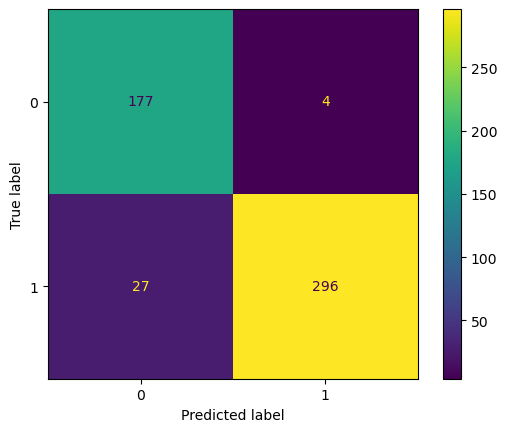

Taking new_annotations to be predicting orig_annotations, we have:
	accuracy: 0.9384920634920635
	precision: 0.9866666666666667
	recall: 0.9164086687306502
	f1: 0.9502407704654896


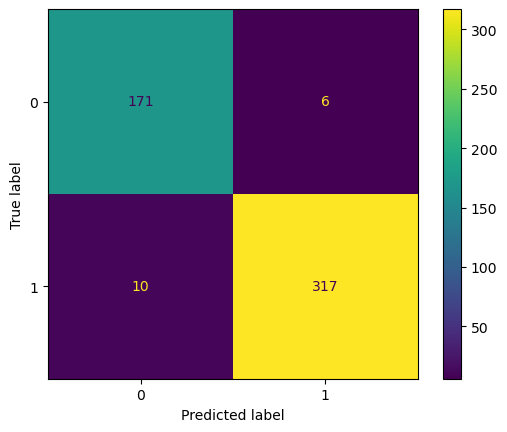

Taking gpt_annotations to be predicting new_annotations, we have:
	accuracy: 0.9682539682539683
	precision: 0.9814241486068112
	recall: 0.9694189602446484
	f1: 0.9753846153846154


In [5]:
compareColumns("../../data/test/ann_combo.csv", "new_annotations", "orig_annotations", "newOrigDiff.txt")
compareColumns("../../data/test/ann_combo.csv", "gpt_annotations", "new_annotations", "gptNewDiff.txt")
# compareColumns("../data/test/ann_combo.csv", "gpt_annotations", "orig_annotations", "gptOrigDiff.txt")

### Analysis of keywords and classification

In [16]:
import textwrap
NLP = spacy.load('en_core_web_sm')

In [17]:
def hasVaccineKeyword(text):
    tokenized = NLP(text)
    lemmatized = [token.lemma_.lower() for token in tokenized]

    return "vacc" in lemmatized or "vaccine" in lemmatized or "vaccinate" in lemmatized or "vaccination" in lemmatized or "immunize" in lemmatized

In [18]:
print(hasVaccineKeyword("he is immunized"))
print([token.lemma_.lower() for token in NLP("he is vaccine-related and more")])

True
['he', 'be', 'vaccine', '-', 'relate', 'and', 'more']


In [19]:
df = pd.read_csv('../../data/test/ann_combo.csv')
annCol = df.get("new_annotations").tolist()
parCol = df.get("paragraph_content").tolist()

trueCount = 0; trueAndHasKeyCount = 0; hasKeyCount = 0
nontrivial = []
for truth, par in zip(annCol, parCol):
    hasKey = hasVaccineKeyword(par)
    if truth:
        trueCount += 1
        if hasKey:
            trueAndHasKeyCount += 1
        else:
            nontrivial.append(par)
    if hasKey:
        hasKeyCount += 1
        if not truth:
            print(par)

print("Of the {} paragraphs that are vaccine-related, {} have a vaccine keyword.".format(trueCount, trueAndHasKeyCount))
print("Of the {} paragraphs that have a keyword, {}, were marked as vaccine-related.".format(hasKeyCount, trueAndHasKeyCount))

strOut = ""
for par in nontrivial:
    strOut += "{}\n\n".format(par)

f = open("nontrivial.txt", "w")
f.write(strOut)
f.close()

Of the 323 paragraphs that are vaccine-related, 283 have a vaccine keyword.
Of the 283 paragraphs that have a keyword, 283, were marked as vaccine-related.
